## What does this notebook do?

- Load in the framew from one of the natural movies using AllenSDK

- Apply the Farneback optical flow method from OpenCV with using parameters in tutorial

https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_video/py_lucas_kanade/py_lucas_kanade.html

- The paper is available here: 

http://www.diva-portal.org/smash/get/diva2:273847/FULLTEXT01.pdf

- Write computed flow to the shared directory

- Use the "Plot Optical Flow" notebook to visualize the optical flow

Note: this notebook was developed runing the conda_python2 kernel

## Instructions for installing OpenCV on default EC2 instance

 source activate environment
 
 conda env list
 
 source activate python2
 
 which python
 
 conda install -c conda-forge opencv
 
 which python
 
 ls -lah /home/ec2-user/anaconda3/envs/python2/
 
 sudo chown -R 500:500 /home/ec2-user/anaconda3/envs/python2/
 
 ls -lah /home/ec2-user/anaconda3/envs/python2/
 
 conda install -c conda-forge opencv

In [1]:
import os

import pandas as pd
import matplotlib.pyplot as plt

import cv2

import numpy as np
import scipy as sp

from allensdk.core.brain_observatory_cache import BrainObservatoryCache

In [2]:
# Load data section from S3 bucket

drive_path = '/data/allen-brain-observatory/visual-coding-2p'
manifest_path = os.path.join(drive_path, 'manifest.json')

stimulus_name = 'natural_movie_two'
boc = BrainObservatoryCache(manifest_file=manifest_path)

# find one experiment that has natural movie three
ophys_experiments = pd.DataFrame(boc.get_ophys_experiments(stimuli=[stimulus_name]))
data_set = boc.get_ophys_experiment_data(ophys_experiment_id=ophys_experiments['id'].values[0])

input_movie = data_set.get_stimulus_template(stimulus_name)

In [3]:
# smooth the data
smoothed = sp.ndimage.filters.gaussian_filter1d(input_movie, 1.0, 0)
smoothed = sp.ndimage.filters.gaussian_filter1d(smoothed, 1.0, 1)
smoothed = sp.ndimage.filters.gaussian_filter1d(smoothed, 1.0, 2)

In [4]:
# setup output flowx, flowy
nframes = smoothed.shape[0]
flist = range(0,nframes-1,1)
ss = smoothed.shape
ss = tuple([len(flist),ss[1],ss[2]])

vlist = ['flowx','flowy','flowmag','flowang','sframes']
vdict = {}
for v in vlist :
    vdict[v] = np.zeros(ss,dtype='float32')

In [5]:
for idx,f in enumerate(flist):
    
    if (idx%100 == 0) :
        print(f)
    
    prvf = smoothed[f,:,:]
    nextf = smoothed[f+1,:,:]
    flow = cv2.calcOpticalFlowFarneback(prvf,nextf, None, 0.5, 3, 15, 3, 5, 1.2, 0)
    mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
    
    vdict['sframes'][idx,...] = smoothed[f,...]
    vdict['flowx'][idx,...] = flow[...,0]
    vdict['flowy'][idx,...] = flow[...,1]
    vdict['flowmag'][idx,...] = mag
    vdict['flowang'][idx,...] = ang

0
100
200
300
400
500
600
700
800


In [6]:
for v in vdict.keys() :
    fname = os.path.join('/home/ec2-user/SageMaker/shared/lydiang/nm2_optical_flow/', '%s.npy' % v)
    np.save( fname, vdict[v], allow_pickle = False )


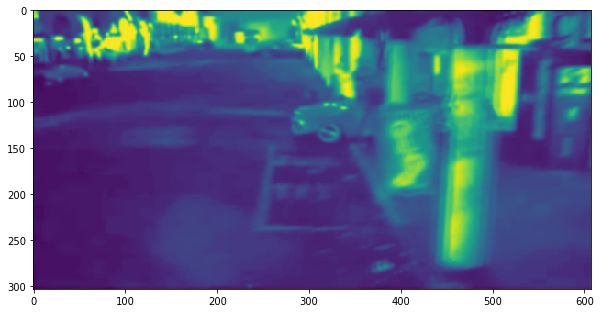

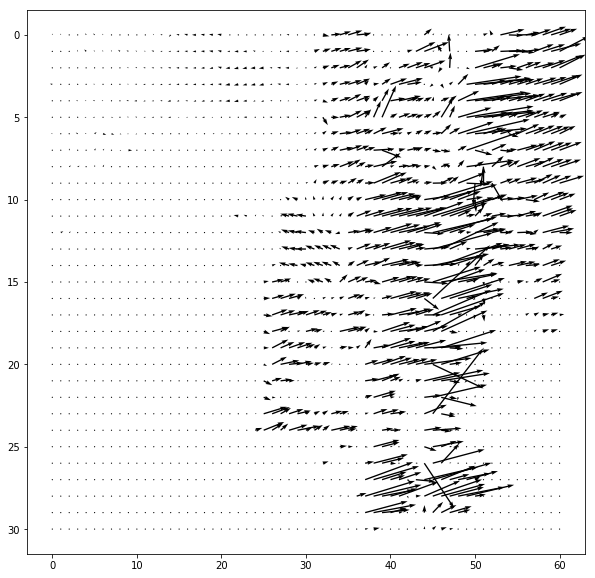

In [7]:
idx = 6*30

plt.figure(figsize=(10, 10))
plt.imshow(vdict['sframes'][idx,...])
plt.show()

U = vdict['flowx'][idx,::10,::10]
V = vdict['flowy'][idx,::10,::10]
plt.figure(figsize=(10, 10))
plt.quiver(U,-V,headwidth=3)
plt.gca().invert_yaxis()